# Heart Risk Prediction using supervised ML

In [1]:
import sklearn
import numpy as np
import io
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.simplefilter(action='ignore')
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
kfold = StratifiedKFold(n_splits=5)

import util

## *Data Loading from Source*

### Using UCI  heart risk data used at kaggle competieion
- Download UCI Cleveland heart risk data available on Kaggle
https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

In [2]:
df_heart_disease = pd.read_csv('heart_disease_dataset_UCI.csv')

## Data Pre-Processing:
- Data cleaning 
- Remove NANs
- Look for missing and unimportant data

## Description of feature vectors:
 - description

It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,
- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp**:         
        0 = typical angina
        1 = atypical angina
        2 = non-anginal pain
        3 = asymptomatic
- **trestbps**: The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol**: The person's cholesterol measurement in mg/dl
- **fbs**: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- **restecg**: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach**: The person's maximum heart rate achieved
- **exang**: Exercise induced angina (1 = yes; 0 = no)
- **oldpeak**: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
- **slope**: 
        0 = upsloping
        1 = flat
        2 = downsloping
- **ca**: The number of major vessels (0-3)
- **thal**: A blood disorder called thalassemia 
        0: NULL (dropped from the dataset previously)
        1: fixed defect (no blood flow in some part of the heart)
        2: normal blood flow
        3: reversible defect (a blood flow is observed but it is not normal)
- **target**: Heart disease (0 = no, 1 = yes)



## Check for Null and NANs
### Need to convert object types to numerical types

In [3]:
df_heart_disease.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [4]:
#df_heart_disease = df_heart_disease.astype(float, errors = 'raise')

In [5]:
#df_heart_disease.dtypes

In [6]:
df_heart_disease.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [7]:
df_heart_disease.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
df_heart_disease.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [9]:
input_features = df_heart_disease.iloc[:,1:]
output_features = df_heart_disease.iloc[:,-1]

In [10]:
df_heart_disease.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Consider rows with target = 1 or target = 0. Ignore other values

In [11]:
df_heart_disease = df_heart_disease[(df_heart_disease['target'] == 1) | (df_heart_disease['target'] == 0)]

In [12]:
df_heart_disease.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


# **_Exploratory Data Analysis_**:
## Check outliers using Inter Quantile Range (IQR):

We are not going to remove outliers since they carry valuable info about certain types of patients. However, it can give us an idea on the necessecity of the exploratory data analysis.

In [13]:
Q1 = df_heart_disease.quantile(0.90)
Q3 = df_heart_disease.quantile(0.10)
IQR = Q3 - Q1

In [14]:
IQR

age         -24.0
sex          -1.0
cp           -2.0
trestbps    -42.0
chol       -120.8
fbs          -1.0
restecg      -1.0
thalach     -60.6
exang        -1.0
oldpeak      -2.8
slope        -1.0
ca           -2.0
thal         -1.0
target       -1.0
dtype: float64

In [15]:
df_heart_disease_IQR = (df_heart_disease < (Q1 - 1.5 * IQR)) |(df_heart_disease > (Q3 + 1.5 * IQR))

In [16]:
df_heart_disease_IQR

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,True,True,True,True,True,True,True,True,True,True,True,True,True,True
299,True,True,True,True,True,True,True,True,True,True,True,True,True,True
300,True,True,True,True,True,True,True,True,True,True,True,True,True,True
301,True,True,True,True,True,True,True,True,True,True,True,True,True,True


### Drop Column which holds outlier

In [17]:
Row_with_outliers = df_heart_disease_IQR.all(axis=0)
indx = Row_with_outliers[Row_with_outliers== False].index.to_list()
indx

[]

In [18]:
df_heart_disease = df_heart_disease.drop(indx, axis = 1)

In [19]:
df_heart_disease.reset_index(drop=True, inplace=True)

In [20]:
df_heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


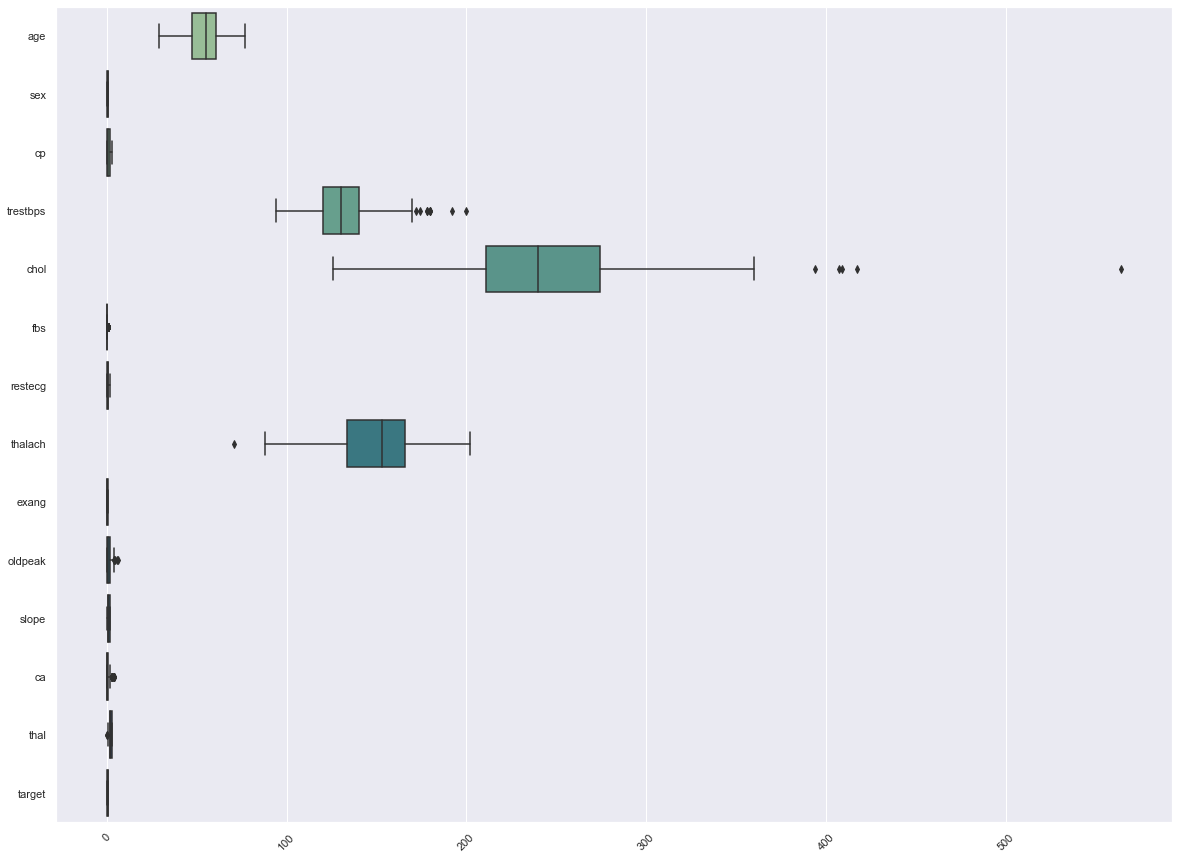

In [21]:
fig, out_fig = plt.subplots(figsize = (20,15))
plt.xticks(rotation=45)
out_fig = sns.boxplot(data = df_heart_disease, orient="h", palette="crest")

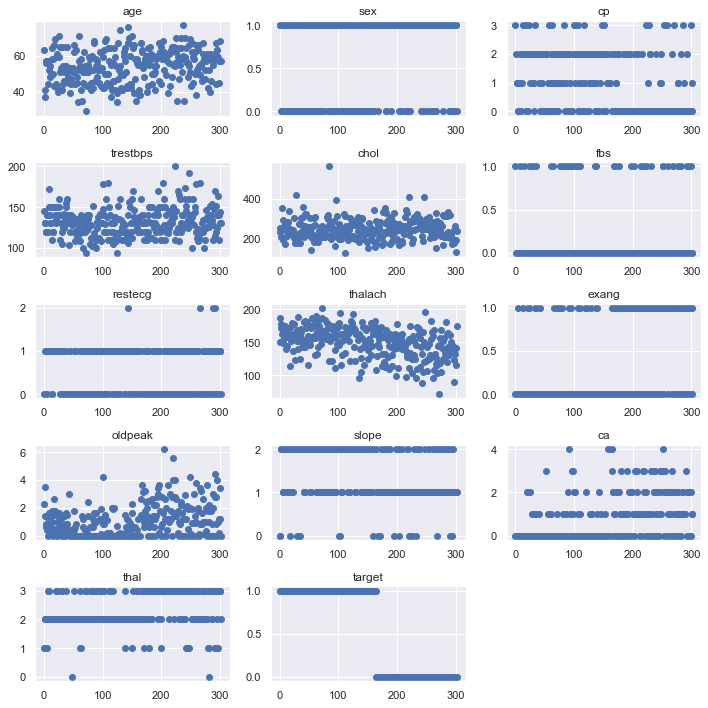

In [22]:
for i,col in enumerate(df_heart_disease.columns.values):
    plt.subplot(5,3,i+1)
    plt.scatter([i for i in range(303)],df_heart_disease[col].values.tolist())
    plt.title(col)
    fig,ax=plt.gcf(),plt.gca()
    fig.set_size_inches(10,10)
    plt.tight_layout()
plt.show()

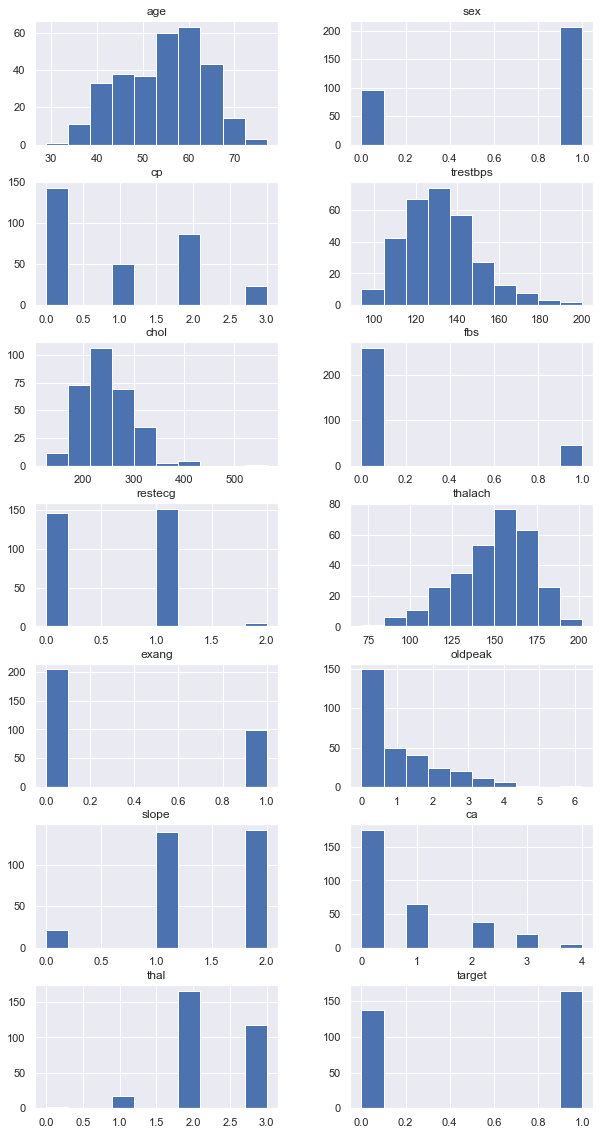

In [23]:
%matplotlib inline
fig, axis = plt.subplots(7,2,figsize=(10, 20));
df_heart_disease.hist(ax=axis);

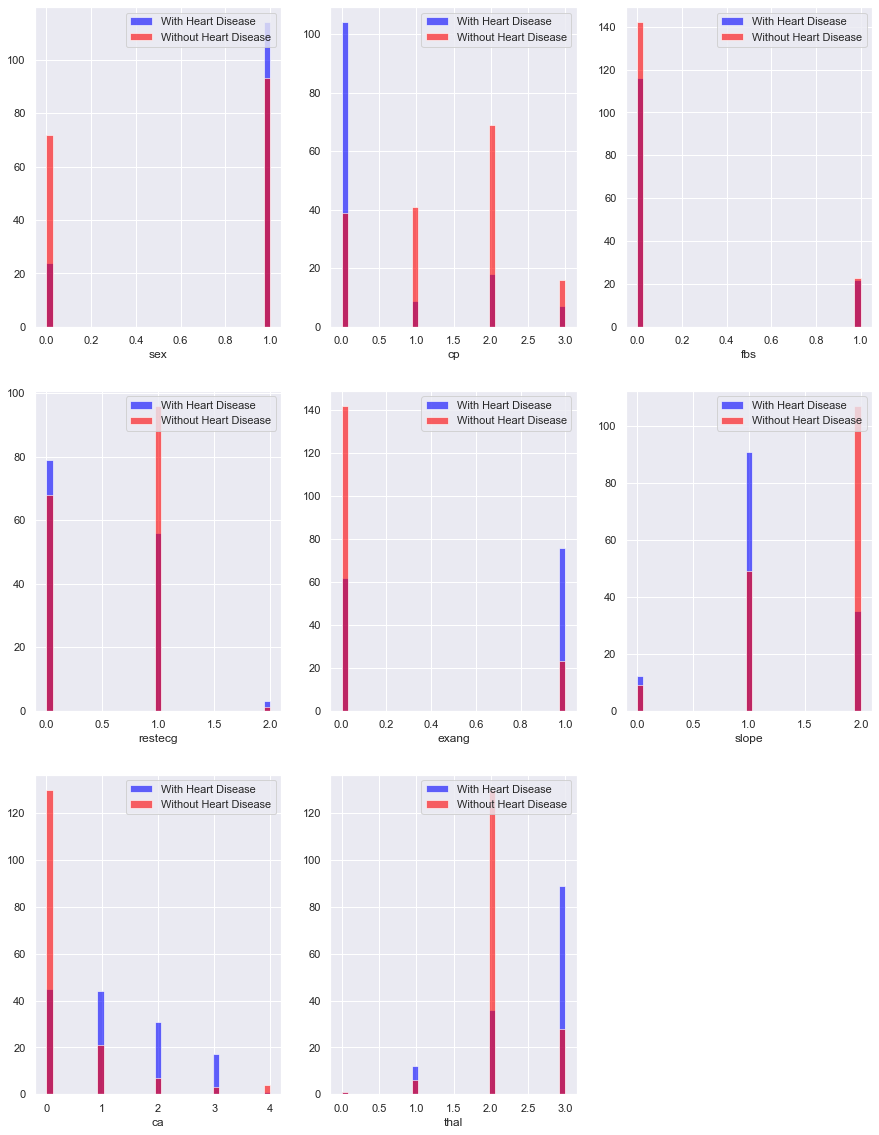

In [24]:
categorical_val = []
continous_val = []

for column in df_heart_disease.columns:
    if len(df_heart_disease[column].unique()) <= 15:
        categorical_val.append(column)
    else:
        continous_val.append(column)
        
plt.figure(figsize=(15, 20))
for i, column in enumerate(categorical_val[:-1], 1):
    plt.subplot(3, 3, i)
    df_heart_disease[df_heart_disease["target"] == 0][column].hist(bins=35, color='blue', label='With Heart Disease', alpha=0.6)
    df_heart_disease[df_heart_disease["target"] == 1][column].hist(bins=35, color='red', label='Without Heart Disease', alpha=0.6)
    plt.legend()
    plt.xlabel(column)
    plt.legend(loc='upper right');

In [25]:
def data_Sex(sex):
    if sex == 0:
        return 'female'
    else:
        return 'male'

def data_target(target):
    if target == 0:
        return 'No Heart Disease'
    else:
        return 'With Heart Disease'
    
def data_thal(thal):
    if thal == 0:
        return 'Non conclusive'
    elif thal == 2:
        return 'Normal'
    elif thal == 1:
        return 'Fixed Defect'
    else:
        return 'Reversible defect'

def data_cp(cp):
    if cp == 0:
        return 'Typical angina'
    elif cp == 1:
        return 'Atypical angina'
    elif cp== 2:
        return 'Non-anginal pain'
    else:
        return 'Asymptomatic'
    
def data_restecg(restecg):
    if restecg == 1:
        return 'Normal'
    elif restecg == 0:
        return 'left ventricular hypertrophy'
    else:
        return 'abnormality in ST-T wave'

def data_st_slope(slope):
    if slope == 0:
        return 'downsloping'
    elif slope == 1:
        return 'flat'
    else:
        return 'upsloping'

def data_age(age):
    if age < 30:
        return 'young patients'
    elif age >= 30 and age < 60:
        return 'middle aged patients'
    else:
        return 'elderly patients'
    
def data_chol(chol):
    if chol < 200:
        return 'Normal Cholesterol Level'
    else:
        return 'High Cholesterol Level'    
    
df_heart_disease_with_catagoricalData = df_heart_disease.copy()
df_heart_disease_with_catagoricalData['sex'] = df_heart_disease['sex'].apply(data_Sex)
df_heart_disease_with_catagoricalData['target'] = df_heart_disease['target'].apply(data_target)
df_heart_disease_with_catagoricalData['thal'] = df_heart_disease['thal'].apply(data_thal)
df_heart_disease_with_catagoricalData['cp'] = df_heart_disease['cp'].apply(data_cp)
df_heart_disease_with_catagoricalData['restecg'] = df_heart_disease['restecg'].apply(data_restecg)
df_heart_disease_with_catagoricalData['slope'] = df_heart_disease['slope'].apply(data_st_slope)
df_heart_disease_with_catagoricalData['age_class'] = df_heart_disease['age'].apply(data_age)
df_heart_disease_with_catagoricalData['chol_level'] = df_heart_disease['chol'].apply(data_chol)

In [26]:
col_to_move = df_heart_disease_with_catagoricalData.pop('target')
df_heart_disease_with_catagoricalData.insert(len(df_heart_disease_with_catagoricalData.columns), 'target', col_to_move)

In [27]:
df_heart_disease_with_catagoricalData.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,age_class,chol_level,target
0,63,male,Asymptomatic,145,233,1,left ventricular hypertrophy,150,0,2.3,downsloping,0,Fixed Defect,elderly patients,High Cholesterol Level,With Heart Disease
1,37,male,Non-anginal pain,130,250,0,Normal,187,0,3.5,downsloping,0,Normal,middle aged patients,High Cholesterol Level,With Heart Disease
2,41,female,Atypical angina,130,204,0,left ventricular hypertrophy,172,0,1.4,upsloping,0,Normal,middle aged patients,High Cholesterol Level,With Heart Disease
3,56,male,Atypical angina,120,236,0,Normal,178,0,0.8,upsloping,0,Normal,middle aged patients,High Cholesterol Level,With Heart Disease
4,57,female,Typical angina,120,354,0,Normal,163,1,0.6,upsloping,0,Normal,middle aged patients,High Cholesterol Level,With Heart Disease


In [ ]:
sns.set(rc={'figure.figsize':(6,5), 'xtick.labelsize':10})
sns.countplot(data= df_heart_disease_with_catagoricalData, x='age_class',hue='target')
plt.title('Relationship between age and risk of heart disease \n');
plt.legend(loc='upper right');

In [ ]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.countplot(data= df_heart_disease_with_catagoricalData[df_heart_disease_with_catagoricalData['target']=='With Heart Disease'], x='age',hue='sex')
plt.title('Relationship between gender and risk of heart disease at all age \n');
plt.legend(loc='upper right');

In [ ]:
sns.set(rc={'figure.figsize':(6,5), 'xtick.labelsize':10})
plot_ = sns.countplot(data= df_heart_disease_with_catagoricalData[df_heart_disease_with_catagoricalData['target']=='With Heart Disease'], x='chol_level', hue='sex')
plt.title('Relationship between gender and risk of heart disease at all age with varying cholesterollevel \n');
plt.tight_layout();
plt.legend(loc='upper right');

In [ ]:
sns.set(rc={'figure.figsize':(6, 5), 'xtick.labelsize':10})
plot_ = sns.countplot(data= df_heart_disease_with_catagoricalData, x='chol_level', hue='target')
plt.tight_layout();
plt.legend(loc='upper right');

In [ ]:
sns.set(rc={'figure.figsize':(6, 5), 'xtick.labelsize':10})
sns.countplot(data= df_heart_disease_with_catagoricalData[df_heart_disease_with_catagoricalData['target'] == 'With Heart Disease'], x='sex',hue='thal')
plt.title('Relationship between gender and risk of heart disorder "thalassemia" \n');
plt.legend(loc='upper right');

In [ ]:
sns.set(rc={'figure.figsize':(6, 5), 'xtick.labelsize':10})
sns.countplot(data= df_heart_disease_with_catagoricalData, x='cp',hue='target')
plt.title('Chest Pain varying with existence of heart disease \n');
plt.legend(loc='upper right');

In [ ]:
sns.set(rc={'figure.figsize':(6, 5), 'xtick.labelsize':10})
sns.countplot(data= df_heart_disease_with_catagoricalData, x='chol_level',hue='target')
plt.title('Effect of cholesterol level and  heart disease \n');

In [ ]:
sns.countplot(data= df_heart_disease_with_catagoricalData, x='restecg',hue='target')
plt.title('Resting electrocardiographic measurement varying with existence of heart disease \n');

In [ ]:
plt.figure(figsize=(10,5))
sns.pointplot(x=df_heart_disease['age'],y=df_heart_disease['thalach'],color='red',alpha=0.8)
plt.xlabel('Age',fontsize = 15,color='blue')
plt.xticks(rotation=45)
plt.ylabel('Thalach',fontsize = 15,color='blue')
plt.title('Age vs Thalach',fontsize = 15,color='blue')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.pointplot(x=df_heart_disease['age'],y=df_heart_disease['chol'],color='red', alpha=0.8)
plt.xlabel('Age',fontsize = 15,color='blue')
plt.xticks(rotation=45)
plt.ylabel('Chol',fontsize = 15,color='blue')
plt.title('Age vs Chol',fontsize = 15,color='blue')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.pointplot(x=df_heart_disease['age'],y=df_heart_disease['oldpeak'],color='red', alpha=0.8)
plt.xlabel('Age',fontsize = 15,color='blue')
plt.xticks(rotation=45)
plt.ylabel('Chol',fontsize = 15,color='blue')
plt.title('Age vs oldpeak',fontsize = 15,color='blue')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.pointplot(x=df_heart_disease['age'],y=df_heart_disease['trestbps'],color='red', alpha=0.8)
plt.xlabel('Age',fontsize = 15,color='blue')
plt.xticks(rotation=45)
plt.ylabel('trestbps',fontsize = 15,color='blue')
plt.title('Age vs trestbps',fontsize = 15,color='blue')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(14,7))
sns.heatmap(df_heart_disease.drop('target', axis=1).corr(),annot=True,cmap="magma",fmt='.2f');

In [ ]:
import hvplot.pandas

df_heart_disease.drop('target', axis=1).corrwith(df_heart_disease.target).hvplot.barh(
    width=600, height=400, 
    title="Correlation between Heart Disease and Feature Vector", 
    ylabel='Correlation', xlabel='Feature Vector',
)

### Features are not highly correlated. So it is reasonable to use these features to the machine learning model.

# *Important Feature Selection*:
### Univariate Feature Selection

In [28]:
#Top  x% features to consider
fraction_of_top_features = 0.8

X = df_heart_disease.drop('target', axis=1)
y = df_heart_disease['target']
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.25, random_state=42)

transformer = Normalizer()
X_train_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.transform(X_test)

In [29]:
from sklearn.feature_selection import SelectKBest, chi2
UV_model = SelectKBest(chi2, k='all').fit(X_train_scaled, y_train)
mask = np.argsort(np.flip(UV_model.scores_)) #list of booleans for selected features
best_features_SKBest = [] 
best_features_SKBest = X_train.columns[mask]  

best_features_SKBest

Index(['thalach', 'restecg', 'oldpeak', 'age', 'ca', 'cp', 'exang', 'thal',
       'chol', 'slope', 'sex', 'trestbps', 'fbs'],
      dtype='object')

### Recursive feature elimination with Random Forest Classifier

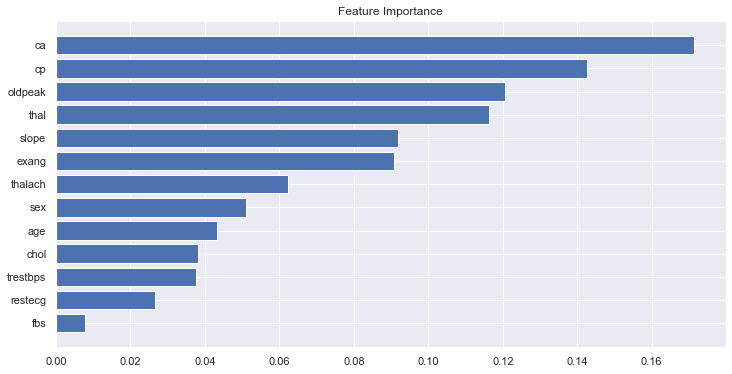

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

model_rf = RandomForestClassifier(n_estimators=1500, max_depth=5)
model_rf.fit(X_train_scaled, y_train)

feature_importance = model_rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')

best_features_rf= X_train.columns[np.flip(sorted_idx)]
best_features_rf = best_features_rf[:int(fraction_of_top_features*len(best_features_rf))]

[23:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


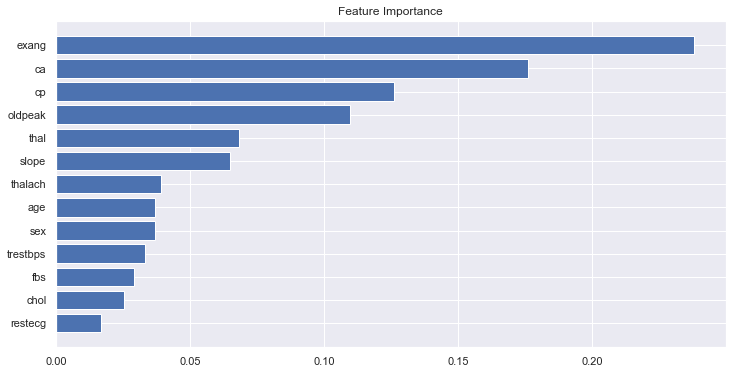

In [31]:
from sklearn.inspection import permutation_importance
import xgboost as xgb

model_xgb = xgb.XGBClassifier(n_estimators=1500, max_depth=5, eta=0.05)
model_xgb.fit(X_train_scaled, y_train)

feature_importance = model_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')

best_features_xgb = X_train.columns[np.flip(sorted_idx)]
best_features_xgb = best_features_xgb[:int(fraction_of_top_features*len(best_features_xgb))]

### Recursive feature elimination with XGBoost Classifier

In [32]:
best_feature_list = list(set.intersection(set(best_features_SKBest), set(best_features_rf), set(best_features_xgb)))

### Use PCA to see how many features are important:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = len(X_train.columns)).fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Significance of principal components', size=20)
plt.show()

Based on PCA seems like first 4 features are significant

### Best Feature Set:

In [ ]:
best_feature_list

### Visualizing simple decision tree based classification using ***Best Feature Set***

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from six import StringIO 
from IPython.display import Image  
import pydotplus

clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)
clf = clf.fit(X_train[best_feature_list],y_train)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=False, rounded=True,
                special_characters=True,feature_names = X_train[best_feature_list].columns  ,class_names=['No Heart Risk','With Heart Risk'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# ML Model Development for heart risk detection

### Get a tuned model that has comparatively highest accuracy:
Use features with numerical values only ***df_heart_disease***

### Use extracted best features from these schemes. 
***best_feature_list***

In [39]:
X_train = X_train[best_feature_list]
X_test  = X_test[best_feature_list]

In [40]:
df_heart_disease = df_heart_disease[best_feature_list + ['target']]

In [41]:
ML_models = []
ML_Prediction_models = []

## *XGBoost based classification for heart risk*

In [42]:
## Hyperparameter optimization using RandomizedSearchCV
import xgboost

In [43]:
#Initialize Model
clf_mdl = xgboost.XGBClassifier(use_label_encoder = False, verbosity = 1, eval_metric='logloss');

params = {
              'objective':['binary:logistic'],
              'learning_rate': [0.001, 0.005, 0.01, 0.1,0.3,0.5,0.7,1], 
              'max_depth': [1, 2, 3, 4, 5, 6, 7],
              'min_child_weight': [1e-5, 1e-3, 1e-2],
              'subsample': [0.01, 0.1, 0.3,0.5,0.7,1],
              'colsample_bytree': [0.7,1],
              'n_estimators': [100, 200, 300, 400, 500, 1000]
}

#Initializing Grid Search with Stratified K Fold
xgb_ml = RandomizedSearchCV(clf_mdl, param_distributions=params, n_jobs=-1, cv=kfold)
xgb_ml.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta...
                                           use_label_encoder=False,
                                           validate_parameters=None,
                                           verbosity=1),
                   n_jobs=-1,
 

In [44]:
xgb_ml.best_params_

{'subsample': 0.01,
 'objective': 'binary:logistic',
 'n_estimators': 1000,
 'min_child_weight': 0.001,
 'max_depth': 1,
 'learning_rate': 1,
 'colsample_bytree': 0.7}

In [45]:
Tuned_model_xgb = xgb_ml.best_estimator_
Tuned_model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=1,
              min_child_weight=0.001, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.01, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [46]:
prediction_xgb = Tuned_model_xgb.predict(X_test)

In [47]:
ML_models.append(Tuned_model_xgb)
ML_Prediction_models.append(prediction_xgb)

In [48]:
cm_xgb = confusion_matrix(y_test, prediction_xgb, labels=None) 

Confusion Matrix
confusion matrix:
[[28  7]
 [ 4 37]]


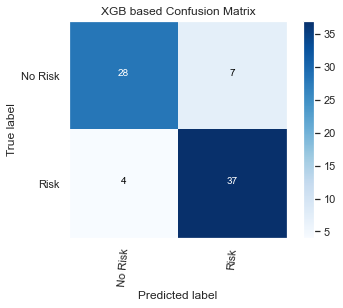

In [49]:
util.plot_confusion_matrix(cm_xgb,classes=['No Risk', 'Risk'], title='XGB based Confusion Matrix')

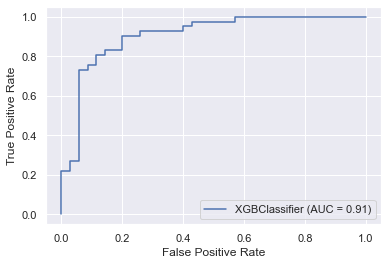

In [50]:
metrics.plot_roc_curve(Tuned_model_xgb, X_test, y_test)

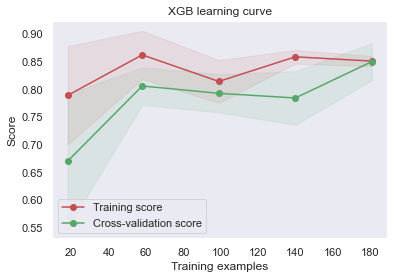

In [51]:
util.plot_learning_curve(estimator = Tuned_model_xgb, title = "XGB learning curve", X = X_train, y = y_train, cv = kfold);

## *Random Forest based classification for heart risk*

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
#Initialize Model
clf_mdl_2 = RandomForestClassifier()

params = {'bootstrap': [True, False],
 'max_depth': range(1,10, 1),
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500]}

#Initializing Grid Search with Stratified K Fold
rf_ml = RandomizedSearchCV(clf_mdl_2, param_distributions=params, n_jobs=-1, cv=kfold)
rf_ml.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': range(1, 10),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]})

In [54]:
rf_ml.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 2,
 'bootstrap': False}

In [55]:
Tuned_model_rf = rf_ml.best_estimator_
Tuned_model_rf

RandomForestClassifier(bootstrap=False, max_depth=2, max_features='sqrt',
                       min_samples_split=10, n_estimators=200)

In [56]:
prediction_rf = Tuned_model_rf.predict(X_test)

In [57]:
ML_models.append(Tuned_model_rf)
ML_Prediction_models.append(prediction_rf)

In [58]:
cm_rf = confusion_matrix(y_test, prediction_rf, labels=None) 

Confusion Matrix
confusion matrix:
[[27  8]
 [ 4 37]]


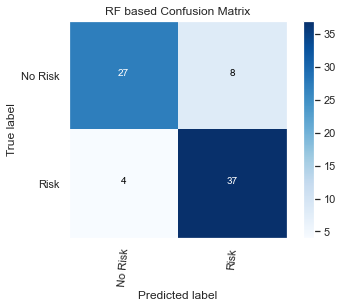

In [59]:
util.plot_confusion_matrix(cm_rf,classes=['No Risk', 'Risk'], title='RF based Confusion Matrix')

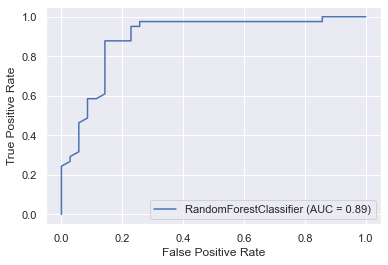

In [60]:
metrics.plot_roc_curve(Tuned_model_rf, X_test, y_test) 

<module 'matplotlib.pyplot' from '/Users/rrahman/Library/Python/3.8/lib/python/site-packages/matplotlib/pyplot.py'>

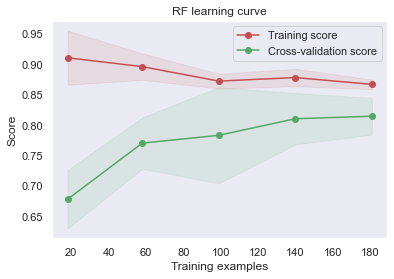

In [61]:
util.plot_learning_curve(estimator = Tuned_model_rf, title = "RF learning curve", X = X_train, y = y_train, cv = kfold)

## *Logistic Regression based classification for heart risk*

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
#Initialize Model
clf_mdl_3 = LogisticRegression()

params = {
    "max_iter": range(100,500,2),
    "solver" : ['newton-cg', 'lbfgs', 'liblinear'],
    "C": [0.5, 0.1, 1.0]
}

lgr_ml = RandomizedSearchCV(clf_mdl_3, param_distributions=params, n_jobs=-1, cv=kfold)
lgr_ml.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.5, 0.1, 1.0],
                                        'max_iter': range(100, 500, 2),
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']})

In [64]:
lgr_ml.best_params_

{'solver': 'liblinear', 'max_iter': 116, 'C': 0.5}

In [65]:
Tuned_model_lgr = lgr_ml.best_estimator_
Tuned_model_lgr

LogisticRegression(C=0.5, max_iter=116, solver='liblinear')

In [66]:
prediction_lgr = Tuned_model_lgr.predict(X_test)

In [67]:
ML_models.append(Tuned_model_lgr)
ML_Prediction_models.append(prediction_lgr)

In [68]:
cm_lgr = confusion_matrix(y_test, prediction_lgr, labels=None) 

Confusion Matrix
confusion matrix:
[[30  5]
 [ 4 37]]


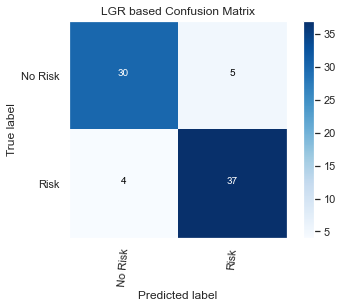

In [69]:
util.plot_confusion_matrix(cm_lgr,classes=['No Risk', 'Risk'], title='LGR based Confusion Matrix')

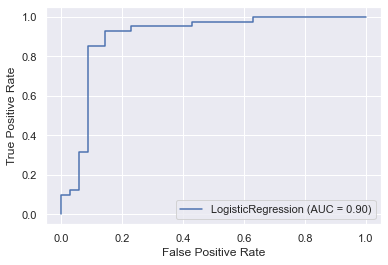

In [70]:
metrics.plot_roc_curve(Tuned_model_lgr, X_test, y_test) 

<module 'matplotlib.pyplot' from '/Users/rrahman/Library/Python/3.8/lib/python/site-packages/matplotlib/pyplot.py'>

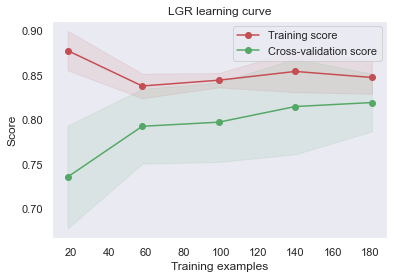

In [71]:
util.plot_learning_curve(estimator = Tuned_model_lgr, title = "LGR learning curve", X = X_train, y = y_train, cv = kfold)

## *LightGBM based classification for heart risk*

In [72]:
## Hyperparameter optimization using RandomizedSearchCV
import lightgbm as lgb

In [73]:
#Initialize Model
clf_mdl_4 = lgb.LGBMClassifier();

params = {'num_leaves':range(10,100, 10), 'min_child_samples':range(5,25,5),'max_depth': range(5, 15, 1),
             'learning_rate':[0.05,0.1,0.2],'reg_alpha': [0,0.01,0.03]}

#Initializing Grid Search with Stratified K Fold
lgb_ml = RandomizedSearchCV(clf_mdl_4, param_distributions=params, n_jobs=-1, cv=kfold)
lgb_ml.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': range(5, 15),
                                        'min_child_samples': range(5, 25, 5),
                                        'num_leaves': range(10, 100, 10),
                                        'reg_alpha': [0, 0.01, 0.03]})

In [74]:
lgb_ml.best_params_

{'reg_alpha': 0,
 'num_leaves': 80,
 'min_child_samples': 20,
 'max_depth': 9,
 'learning_rate': 0.2}

In [75]:
Tuned_model_lgb = lgb_ml.best_estimator_
Tuned_model_lgb

LGBMClassifier(learning_rate=0.2, max_depth=9, num_leaves=80, reg_alpha=0)

In [76]:
prediction_lgb = Tuned_model_lgb.predict(X_test)

In [77]:
ML_models.append(Tuned_model_lgb)
ML_Prediction_models.append(prediction_lgb)

In [78]:
cm_lgb = confusion_matrix(y_test, prediction_lgb, labels=None) 

Confusion Matrix
confusion matrix:
[[27  8]
 [ 7 34]]


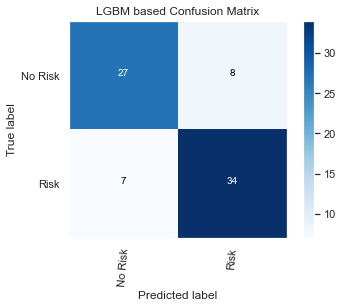

In [79]:
util.plot_confusion_matrix(cm_lgb,classes=['No Risk', 'Risk'], title='LGBM based Confusion Matrix')

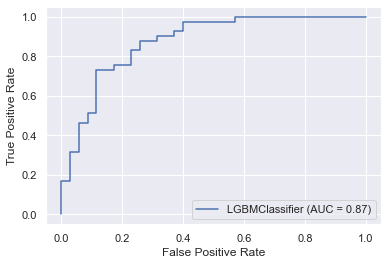

In [80]:
metrics.plot_roc_curve(Tuned_model_lgb, X_test, y_test) 

<module 'matplotlib.pyplot' from '/Users/rrahman/Library/Python/3.8/lib/python/site-packages/matplotlib/pyplot.py'>

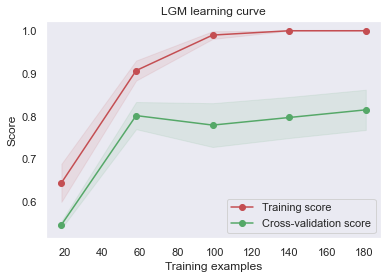

In [81]:
util.plot_learning_curve(estimator = Tuned_model_lgb, title = "LGM learning curve", X = X_train, y = y_train, cv = kfold)

## *Linear Discriminant Analysis based classification for heart risk*

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [83]:
#Initialize Model
clf_mdl_5 = LinearDiscriminantAnalysis()

params = {
    "solver" : ["svd"],
     "tol" : [0.0001,0.0002,0.0003]
}

lda_ml = RandomizedSearchCV(clf_mdl_5, param_distributions=params, n_jobs=-1, cv=kfold)
lda_ml.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
                   param_distributions={'solver': ['svd'],
                                        'tol': [0.0001, 0.0002, 0.0003]})

In [84]:
lda_ml.best_params_

{'tol': 0.0001, 'solver': 'svd'}

In [85]:
Tuned_model_lda = lda_ml.best_estimator_
Tuned_model_lda

LinearDiscriminantAnalysis()

In [86]:
prediction_lda = Tuned_model_lda.predict(X_test)

In [87]:
ML_models.append(Tuned_model_lda)
ML_Prediction_models.append(prediction_lda)

In [88]:
cm_lda = confusion_matrix(y_test, prediction_lda, labels=None) 

Confusion Matrix
confusion matrix:
[[29  6]
 [ 4 37]]


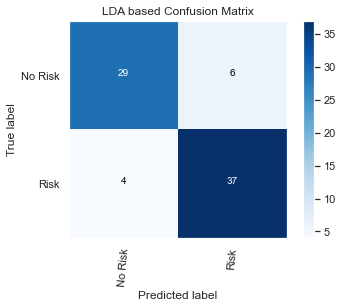

In [89]:
util.plot_confusion_matrix(cm_lda,classes=['No Risk', 'Risk'], title='LDA based Confusion Matrix')

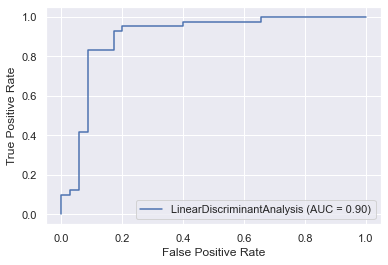

In [90]:
metrics.plot_roc_curve(Tuned_model_lda, X_test, y_test) 

<module 'matplotlib.pyplot' from '/Users/rrahman/Library/Python/3.8/lib/python/site-packages/matplotlib/pyplot.py'>

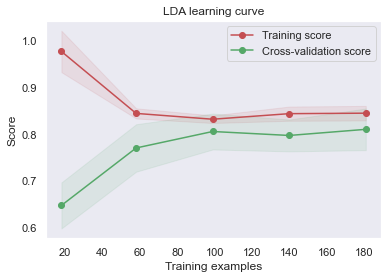

In [91]:
util.plot_learning_curve(estimator = Tuned_model_lda, title = "LDA learning curve", X = X_train, y = y_train, cv = kfold)

## *Ensemble learning based classification for heart risk*

In [92]:
from sklearn.ensemble import VotingClassifier

In [93]:
VotingPredictor = VotingClassifier(estimators =
                           [('rfc', Tuned_model_rf), 
                            ('lgr', Tuned_model_lgr), 
                            ('lda', Tuned_model_lda),
                            ('xgb', Tuned_model_xgb),
                            ('lgb', Tuned_model_lgb)],
                           voting='soft', n_jobs = -1)


VotingPredictor = VotingPredictor.fit(X_train, y_train);

In [94]:
prediction_vp = VotingPredictor.predict(X_test)

In [95]:
ML_models.append(VotingPredictor)
ML_Prediction_models.append(prediction_vp)

In [96]:
cm_vp = confusion_matrix(y_test, prediction_vp, labels=None) 

Confusion Matrix
confusion matrix:
[[28  7]
 [ 3 38]]


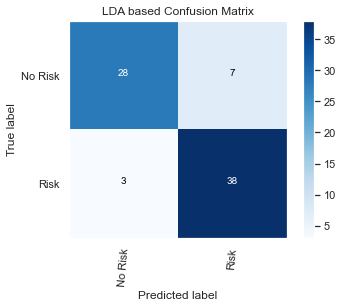

In [97]:
util.plot_confusion_matrix(cm_vp,classes=['No Risk', 'Risk'], title='LDA based Confusion Matrix')

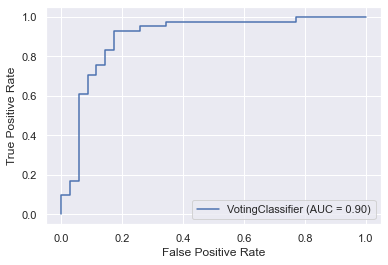

In [98]:
metrics.plot_roc_curve(VotingPredictor, X_test, y_test) 

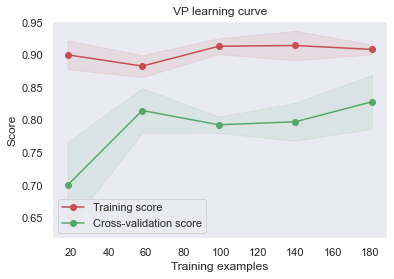

In [99]:
util.plot_learning_curve(estimator = VotingPredictor, title = "VP learning curve",
                    X = X_train, y = y_train, cv = kfold);

In [109]:
Metrics_df = pd.DataFrame()

data_dict = {}

model_name = []
model_metrics = []

for item in enumerate(ML_models):
    y_pred = ML_Prediction_models[item[0]]
    recall_scr = recall_score(y_test, y_pred)
    f1_scr = f1_score(y_test, y_pred)   
    precision_scr = precision_score(y_test, y_pred) 
    accuracy_scr = accuracy_score(y_test, y_pred)
    roc_auc_scr = roc_auc_score(y_test, y_pred)    
    cross_val_scr = cross_val_score(ML_models[item[0]], X_train, y_train,cv=10, n_jobs = -1, scoring = 'accuracy').mean()
    model_name.append(type(ML_models[item[0]]).__name__)
    model_metrics.append([recall_scr, f1_scr, precision_scr, accuracy_scr, roc_auc_scr, cross_val_scr])


for i in range(len(model_name)):
    data_dict[model_name[i]] = model_metrics[i]


In [110]:
metrics_name = ['recall', 'f1', 'precision','accuracy', 'roc_auc', 'cross_validation']
Metrics_df = pd.DataFrame.from_dict(data_dict, orient='index', columns=metrics_name)
Metrics_df.head()

,recall,f1,precision,accuracy,roc_auc,cross_validation
XGBClassifier,0.902439,0.870588,0.840909,0.855263,0.851220,0.819368
RandomForestClassifier,0.902439,0.860465,0.822222,0.842105,0.836934,0.833004
LogisticRegression,0.902439,0.891566,0.880952,0.881579,0.879791,0.823913
LGBMClassifier,0.829268,0.819277,0.809524,0.802632,0.800348,0.815217
LinearDiscriminantAnalysis,0.902439,0.880952,0.860465,0.868421,0.865505,0.815217


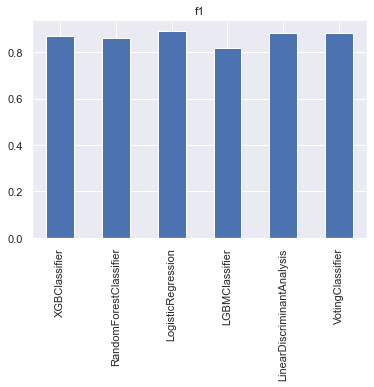

In [117]:
Metrics_df['f1'].plot(kind="bar",title='f1');

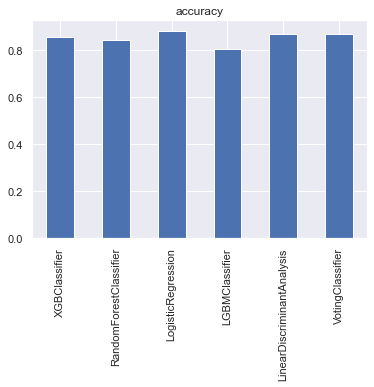

In [118]:
Metrics_df['accuracy'].plot(kind="bar", title='accuracy');

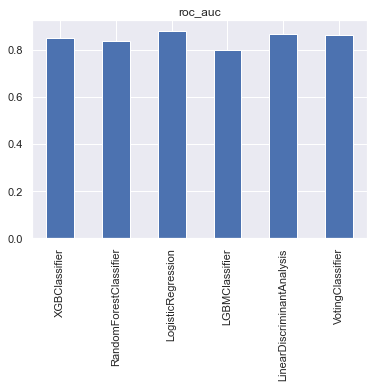

In [116]:
Metrics_df['roc_auc'].plot(kind="bar", title='roc_auc');

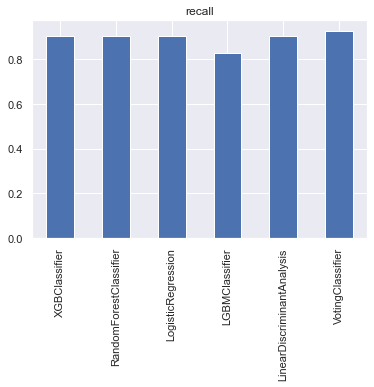

In [119]:
Metrics_df['recall'].plot(kind="bar", title='recall');

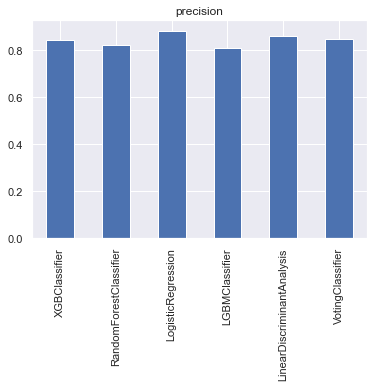

In [120]:
Metrics_df['precision'].plot(kind="bar", title='precision');